<a href="https://colab.research.google.com/github/paolaCaushi/anomalyDetectionWithTransferLearning/blob/GBM/GBM_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup and Preprocessing**

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Drop the 'idPunto' and 'note' columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


# **Training and Evaluating XGBoost**

In [3]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb}')
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9316770186335404
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       297
           1       0.57      0.48      0.52        25

    accuracy                           0.93       322
   macro avg       0.76      0.72      0.74       322
weighted avg       0.93      0.93      0.93       322



Anomalies from the training of XGBoost shown in a map

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
import folium
from IPython.display import display

# Load the dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Replace commas with dots in latitude and longitude columns and convert to float
df['latitudine'] = df['latitudine'].astype(str).str.replace(',', '.').astype(float)
df['longitudine'] = df['longitudine'].astype(str).str.replace(',', '.').astype(float)

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Drop the 'idPunto' and 'note' columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

# Predict anomalies on the entire dataset
X_full = preprocessor.transform(X)
df['Predicted_Target'] = model.predict(X_full)

# Filter anomalies (where Predicted_Target is 1)
anomalies = df[df['Predicted_Target'] == 1]

# Check if anomalies DataFrame is empty
if anomalies.empty:
    print("No anomalies detected.")
else:
    # Create a map centered at the average location of anomalies
    map_center = [anomalies['latitudine'].mean(), anomalies['longitudine'].mean()]
    m = folium.Map(location=map_center, zoom_start=12)

    # Add points to the map with CircleMarker
    for _, row in anomalies.iterrows():
        folium.CircleMarker(
            location=[row['latitudine'], row['longitudine']],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            popup=f"ID: {row.get('id', 'N/A')}<br>Note: {row.get('note', 'N/A')}"
        ).add_to(m)

    # Display the map within the notebook
    display(m)


# **Training and Evaluating LightGBM**

In [4]:
import lightgbm as lgb

# Train the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lgb = lgb_model.predict(X_test)
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# Evaluate the LightGBM model
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f'LightGBM Accuracy: {accuracy_lgb}')
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))


[LightGBM] [Info] Number of positive: 80, number of negative: 1206
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1056
[LightGBM] [Info] Number of data points in the train set: 1286, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062208 -> initscore=-2.713038
[LightGBM] [Info] Start training from score -2.713038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 0.9161490683229814
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       297
           1       0.45      0.40      0.43

Anomalies shown in a map after training LightGBM

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import folium
from IPython.display import display

# Load the dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Replace commas with dots in latitude and longitude columns and convert to float
df['latitudine'] = df['latitudine'].astype(str).str.replace(',', '.').astype(float)
df['longitudine'] = df['longitudine'].astype(str).str.replace(',', '.').astype(float)

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Drop the 'idPunto' and 'note' columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Train LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# Predict anomalies on the entire dataset
X_full = preprocessor.transform(X)
df['Predicted_Target'] = model.predict(X_full)

# Filter anomalies (where Predicted_Target is 1)
anomalies = df[df['Predicted_Target'] == 1]

# Check if anomalies DataFrame is empty
if anomalies.empty:
    print("No anomalies detected.")
else:
    # Create a map centered at the average location of anomalies
    map_center = [anomalies['latitudine'].mean(), anomalies['longitudine'].mean()]
    m = folium.Map(location=map_center, zoom_start=12)

    # Add points to the map with CircleMarker
    for _, row in anomalies.iterrows():
        folium.CircleMarker(
            location=[row['latitudine'], row['longitudine']],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            popup=f"ID: {row.get('id', 'N/A')}<br>Note: {row.get('note', 'N/A')}"
        ).add_to(m)

    # Display the map within the notebook
    display(m)


[LightGBM] [Info] Number of positive: 80, number of negative: 1206
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 1286, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062208 -> initscore=-2.713038
[LightGBM] [Info] Start training from score -2.713038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

# **Training and Evaluating CatBoost**

In [5]:
!pip install xgboost lightgbm catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.0 MB/s eta 0:00:00


In [6]:
from catboost import CatBoostClassifier

# Train the CatBoost model
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)

# Predict on the test set
y_pred_cat = cat_model.predict(X_test)
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]

# Evaluate the CatBoost model
accuracy_cat = accuracy_score(y_test, y_pred_cat)
print(f'CatBoost Accuracy: {accuracy_cat}')
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))


CatBoost Accuracy: 0.9565217391304348
CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       297
           1       0.92      0.48      0.63        25

    accuracy                           0.96       322
   macro avg       0.94      0.74      0.80       322
weighted avg       0.96      0.96      0.95       322



Anomalies detected from CatBoost shown in a map

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import folium
from IPython.display import display

# Load the dataset
data_file = "Anomalies_2021_2024.xlsx"
df = pd.read_excel(data_file, sheet_name="Sheet1", header=0)

# Replace commas with dots in latitude and longitude columns and convert to float
df['latitudine'] = df['latitudine'].astype(str).str.replace(',', '.').astype(float)
df['longitudine'] = df['longitudine'].astype(str).str.replace(',', '.').astype(float)

# Create target variable based on 'idPunto' being null and 'note' being 12 or 6
df['Target'] = df.apply(lambda row: 1 if pd.isnull(row['idPunto']) and row['note'] in [12, 6] else 0, axis=1)

# Drop the 'idPunto' and 'note' columns
df = df.drop(columns=['idPunto', 'note'])

# Convert datetime columns to numeric
datetime_columns = ['dataAnomalia', 'dataCoordinate', 'dataSegnalazione']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9

# Fill NaN values in datetime columns with median
for col in datetime_columns:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns to string type
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].astype(str)

# Separate features and target variable
X = df.drop(columns=['Target'])
y = df['Target']

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines for numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Train the CatBoost model
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)


# Predict anomalies on the entire dataset
X_full = preprocessor.transform(X)
df['Predicted_Target'] = model.predict(X_full)

# Filter anomalies (where Predicted_Target is 1)
anomalies = df[df['Predicted_Target'] == 1]

# Check if anomalies DataFrame is empty
if anomalies.empty:
    print("No anomalies detected.")
else:
    # Create a map centered at the average location of anomalies
    map_center = [anomalies['latitudine'].mean(), anomalies['longitudine'].mean()]
    m = folium.Map(location=map_center, zoom_start=12)

    # Add points to the map with CircleMarker
    for _, row in anomalies.iterrows():
        folium.CircleMarker(
            location=[row['latitudine'], row['longitudine']],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7,
            popup=f"ID: {row.get('id', 'N/A')}<br>Note: {row.get('note', 'N/A')}"
        ).add_to(m)

    # Display the map within the notebook
    display(m)


# **Plotting the ROC Curves for the three models**

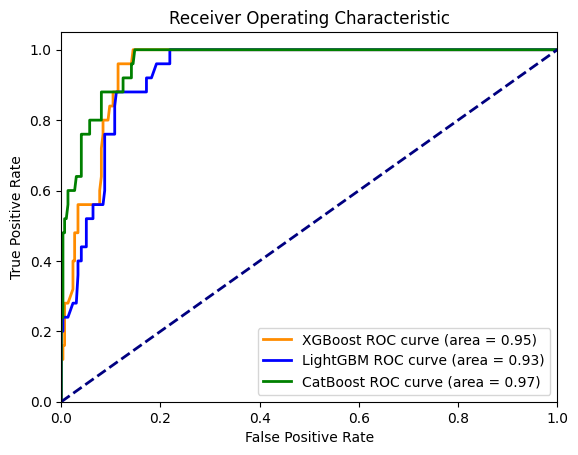

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curves and AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

fpr_cat, tpr_cat, _ = roc_curve(y_test, y_pred_proba_cat)
roc_auc_cat = auc(fpr_cat, tpr_cat)

# Plot ROC curves
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgb, tpr_lgb, color='blue', lw=2, label=f'LightGBM ROC curve (area = {roc_auc_lgb:.2f})')
plt.plot(fpr_cat, tpr_cat, color='green', lw=2, label=f'CatBoost ROC curve (area = {roc_auc_cat:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# **Comparing the three models**

In [8]:
# XGBoost
print(f'XGBoost Accuracy: {accuracy_xgb}')
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# LightGBM
print(f'LightGBM Accuracy: {accuracy_lgb}')
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgb))

# CatBoost
print(f'CatBoost Accuracy: {accuracy_cat}')
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))


XGBoost Accuracy: 0.9316770186335404
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       297
           1       0.57      0.48      0.52        25

    accuracy                           0.93       322
   macro avg       0.76      0.72      0.74       322
weighted avg       0.93      0.93      0.93       322

LightGBM Accuracy: 0.9161490683229814
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       297
           1       0.45      0.40      0.43        25

    accuracy                           0.92       322
   macro avg       0.70      0.68      0.69       322
weighted avg       0.91      0.92      0.91       322

CatBoost Accuracy: 0.9565217391304348
CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       297
           1       0.92      

# **Precision-Recall Curve**

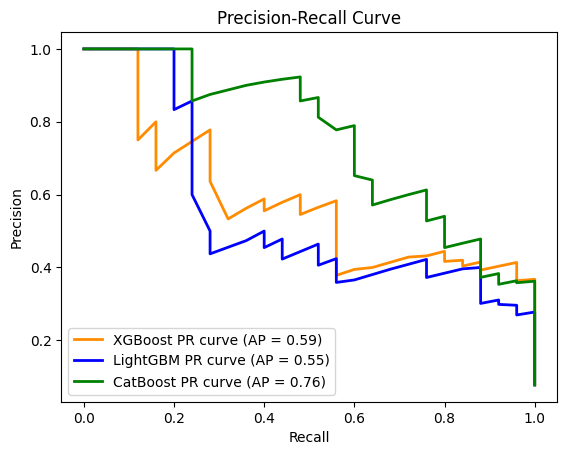

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall curves and Average Precision Scores
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
average_precision_xgb = average_precision_score(y_test, y_pred_proba_xgb)

precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, y_pred_proba_lgb)
average_precision_lgb = average_precision_score(y_test, y_pred_proba_lgb)

precision_cat, recall_cat, _ = precision_recall_curve(y_test, y_pred_proba_cat)
average_precision_cat = average_precision_score(y_test, y_pred_proba_cat)

plt.figure()
plt.plot(recall_xgb, precision_xgb, color='darkorange', lw=2, label=f'XGBoost PR curve (AP = {average_precision_xgb:.2f})')
plt.plot(recall_lgb, precision_lgb, color='blue', lw=2, label=f'LightGBM PR curve (AP = {average_precision_lgb:.2f})')
plt.plot(recall_cat, precision_cat, color='green', lw=2, label=f'CatBoost PR curve (AP = {average_precision_cat:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


# **Calibration Curve**

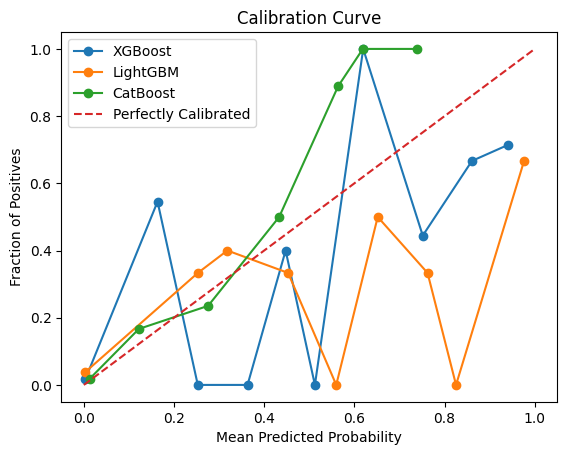

In [10]:
from sklearn.calibration import calibration_curve

# Calibration curves
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, y_pred_proba_xgb, n_bins=10)
prob_true_lgb, prob_pred_lgb = calibration_curve(y_test, y_pred_proba_lgb, n_bins=10)
prob_true_cat, prob_pred_cat = calibration_curve(y_test, y_pred_proba_cat, n_bins=10)

plt.figure()
plt.plot(prob_pred_xgb, prob_true_xgb, marker='o', label='XGBoost')
plt.plot(prob_pred_lgb, prob_true_lgb, marker='o', label='LightGBM')
plt.plot(prob_pred_cat, prob_true_cat, marker='o', label='CatBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc="upper left")
plt.show()


# **Lift Chart**

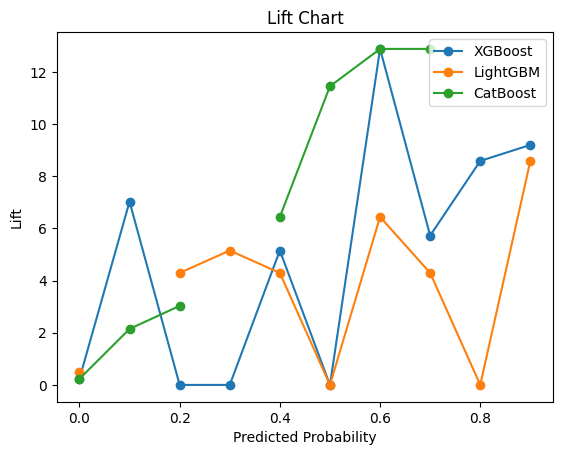

In [11]:
# Lift Chart
bins = np.linspace(0, 1, 11)

def calculate_lift(y_true, y_pred_proba, bins):
    binned = np.digitize(y_pred_proba, bins) - 1
    lift = [np.mean(y_true[binned == i]) / np.mean(y_true) for i in range(len(bins))]
    return lift

lift_xgb = calculate_lift(y_test, y_pred_proba_xgb, bins)
lift_lgb = calculate_lift(y_test, y_pred_proba_lgb, bins)
lift_cat = calculate_lift(y_test, y_pred_proba_cat, bins)

plt.figure()
plt.plot(bins[:-1], lift_xgb[:-1], marker='o', label='XGBoost')
plt.plot(bins[:-1], lift_lgb[:-1], marker='o', label='LightGBM')
plt.plot(bins[:-1], lift_cat[:-1], marker='o', label='CatBoost')
plt.xlabel('Predicted Probability')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend(loc="upper right")
plt.show()
